<img src='images/bc.png'>

<center><h1> Prédire le temps de stationnement des conteneurs </h1></center>

# Contexte

Plus de 80% des biens consommés dans le monde sont transportés par voie maritime dans des conteneurs.
L’invention du conteneur n’est pas moins que la plus grande révolution de notre société moderne depuis
l’avènement d’internet. Il est à la base de notre ”supply chain” moderne et de la mondialisation qui s’est
produite ces 30 dernières années.
Chaque jour, des millions de conteneurs sont chargés et déchargés des navires de marchandises. A l’importation,
les opérateurs de terminaux portuaires déchargent les conteneurs des navires et les stockent sur un parc à
conteneur en attendant leur sortie par camion. Dès la sortie du navire, on souhaite placer les conteneurs en
fonction de leur ordre de sortie afin d’éviter tout mouvement improductif de conteneur. Etant donné que le
port n’a aucune visibilité sur l’arrivée des camions (chaque camion vient chercher un conteneur qui lui est
attitré), vous souhaitez prédire la durée de stationnement des conteneurs sur le parc afin de déterminer le
moment de leur sortie.

<img src='images/conteneurs.jpg'>

# Description des données
- id container : référence du conteneur
- feet : longueur du conteneur
- reefer : conteneur réfrigéré ou non
- hazardous : conteneur dangereux ou non
- weight : poids du conteneur
- estimated time arrival : date d’arrivée des conteneurs estimée
- actual time arrival : date d’arrivée des conteneurs effective
- id port call : référence de l’escale du navire
- shipping line : compagnie maritime
- freight forwarder : transitaire (responsable du transport depuis l’origine jusqu’au client final)
- trucking company : compagnie de transport routier
- final destination : destination finale
- dwelltime : temps de stationnement des conteneurs (heures)

In [1]:
### Imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Model ###
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU

### Principal Component Analysis ###
import json
import gzip
from sklearn.decomposition import PCA
from scipy import cluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency, pearsonr
from itertools import combinations
import sys
sys.path.append("lib")
from sklearn import decomposition
from sklearn.manifold import TSNE
from ggplot import *
from sklearn.manifold import TSNE

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [250]:
df_train = pd.read_csv("visits_train.csv").drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv("visits_test.csv").drop(['Unnamed: 0'], axis=1)

In [251]:
df_train.shape

(13596, 13)

In [252]:
df_test.shape

(1183, 12)

In [253]:
df = pd.concat([df_train.drop(['dwelltime'], axis=1), df_test], axis=0).reset_index(drop=True)
df.head(15)

,id_container,feet,reefer,hazardous,weight,estimated_time_arrival,actual_time_arrival,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination
0,AMCU9297612,45,1.0,NaN,31978.0,15/02/2017,15/02/2017,19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE
1,MRKU9718477,20,NaN,NaN,21141.0,30/12/2016,30/12/2016,16A1,BGFREIGHT,JAS,LOGAFRET,COUERON
2,MRKU3391638,45,NaN,NaN,10323.0,30/12/2016,30/12/2016,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
3,MSKU0794884,40,NaN,NaN,10778.0,NaN,30/12/2016,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
4,TEMU2871681,20,NaN,NaN,5200.0,30/12/2016,30/12/2016,095ACR,CMA,MTTM,NAUL,X
5,MSKU1413621,40,NaN,NaN,6944.0,30/12/2016,30/12/2016,16A1,BGFREIGHT,DAHER,SARRION,ST MICHEL
6,ECMU1873953,20,NaN,NaN,23763.0,30/12/2016,30/12/2016,095ACR,CMA,SOGEB,AVRIL,ST AIGNAN
7,FCIU5679677,20,NaN,NaN,23997.0,30/12/2016,30/12/2016,095ACR,CMA,SOGEB,AVRIL,ST AIGNAN
8,TCLU7463031,20,NaN,NaN,NaN,30/12/2016,30/12/2016,095ACR,CMA,SOGEB,AVRIL,ST AIGNAN
9,TEMU2298456,20,NaN,1.0,9020.0,30/12/2016,30/12/2016,095ACR,CMA,LEON,SARRION,X


In [254]:
df.shape

(14779, 12)

# Instructions

1. *Identifier une visite* : 
Un conteneur (en tant que boite) peut revenir plusieurs fois dans l’année, vous devrez donc comprendre comment identifer une ”visite”.

2. *Prédire le temps de stationnement* :
Vous devrez créer un modèle permettant de prédire le temps de stationnement pour les visites du fichier de
test. Vous chercherez à estimer l’intervalle de confiance de vos prédictions. Vous choisirez la métrique MAPE
(Mean Absolute Pourcentage Error) afin de juger et optimiser la performance de vos prédictions. En effet, il
est important de minimiser les erreurs en pourcentage de la durée de stationnement afin de pas être pénalisé
par les trop grandes valeurs.

# Analyse exploratoire

## Traiter les valeurs manquantes

Commençons par estimer le nombre de valeurs manquantes :

In [255]:
df.isnull().sum()

id_container                  0
feet                          0
reefer                    14613
hazardous                 14483
weight                     1448
estimated_time_arrival      298
actual_time_arrival           0
id_port_call                  0
shipping_line                 0
freight_forwarder           125
trucking_company              0
final_destination             0
dtype: int64

Premièrement, il faut traiter les valeurs manquantes :
- mettre des 0 dans les colonnes reefer et hazardous
- remplacer les poids manquants par des valeurs moyennes
- remplacer le temps d'arrivée estimé par la date actuelle d'arrviée moins le temps moyen entre ces deux dates
- remplacer les companies de fret manquantes par une catégorie additionnelle

### Reefer, Hazardous

In [256]:
df['reefer'] = df['reefer'].fillna(0)
df['hazardous'] = df['hazardous'].fillna(0)

In [257]:
df.head()

,id_container,feet,reefer,hazardous,weight,estimated_time_arrival,actual_time_arrival,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination
0,AMCU9297612,45,1.0,0.0,31978.0,15/02/2017,15/02/2017,19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE
1,MRKU9718477,20,0.0,0.0,21141.0,30/12/2016,30/12/2016,16A1,BGFREIGHT,JAS,LOGAFRET,COUERON
2,MRKU3391638,45,0.0,0.0,10323.0,30/12/2016,30/12/2016,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
3,MSKU0794884,40,0.0,0.0,10778.0,NaN,30/12/2016,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
4,TEMU2871681,20,0.0,0.0,5200.0,30/12/2016,30/12/2016,095ACR,CMA,MTTM,NAUL,X


On peut maintenant s'intéresser aux ratios de conteneurs réfrigérés et dangereux :

In [258]:
df['reefer'].mean()

0.011232153731646256

In [259]:
df['hazardous'].mean()

0.0200284187022126

### Poids des conteneurs

On estime ensuite le poids moyen des conteneurs:

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


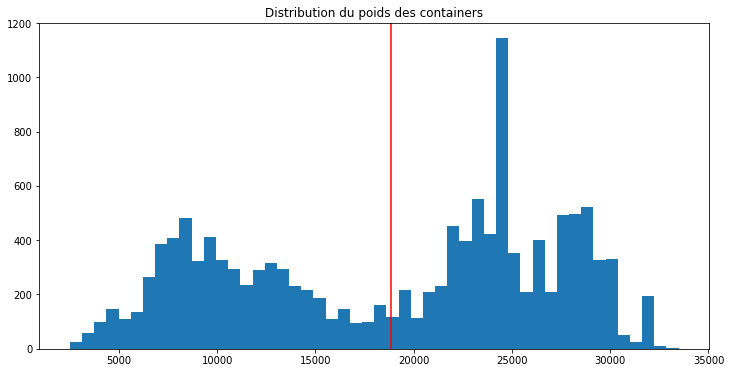

In [260]:
plt.figure(figsize=(12,6))
plt.hist(df['weight'], bins=50)
plt.title("Distribution du poids des containers")
plt.axvline(df['weight'].mean(), c='red')
plt.show()

In [261]:
weight_mean = df['weight'].mean()
df['weight'] = df['weight'].fillna(weight_mean)

### Traiter les dates

In [262]:
df['estimated_time_arrival'] = pd.to_datetime(df['estimated_time_arrival'])

In [263]:
df['actual_time_arrival'] = pd.to_datetime(df['actual_time_arrival'])

In [264]:
df_train['actual_time_arrival'] = pd.to_datetime(df_train['actual_time_arrival'])
df_test['actual_time_arrival'] = pd.to_datetime(df_test['actual_time_arrival'])
df_train['estimated_time_arrival'] = pd.to_datetime(df_train['estimated_time_arrival'])
df_test['estimated_time_arrival'] = pd.to_datetime(df_test['estimated_time_arrival'])

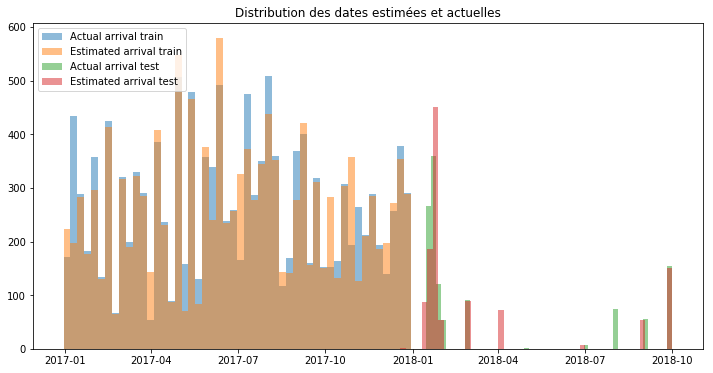

In [265]:
estimated_train = df_train[df_train['estimated_time_arrival'].isnull() == False]['estimated_time_arrival']
estimated_test = df_test[df_test['estimated_time_arrival'].isnull() == False]['estimated_time_arrival']

plt.figure(figsize=(12,6))

plt.hist(df_train['actual_time_arrival'], bins = 50, alpha=0.5, label='Actual arrival train')
plt.hist(estimated_train, bins = 50, alpha=0.5, label='Estimated arrival train')

plt.hist(df_test['actual_time_arrival'], bins = 50, alpha=0.5, label='Actual arrival test')
plt.hist(estimated_test, bins = 50, alpha=0.5, label='Estimated arrival test')

plt.legend(loc='upper left')
plt.title("Distribution des dates estimées et actuelles")
plt.show()

On observe une cohérence entre les deux distributions. Les données sont ordonnées de manière temporelle. Le test set concerne des estimations en 2018, et le train set en 2017. Cela a une implication importante :
- soit il faut modéliser des séries temporelles
- soit on suppose que l'activité est similaire à travers les années, et on ne tient pas compte de l'année mais seulement du mois. Pour des contraintes de tempos et de simiplicité, on partira sur cette option. De plus, on ne peut pas compter le mois de l'année comme une variable explicative car quasiement toutes les données de test sont concentrées sur le mois de janvier. On se concentre alors sur le jour du mois d'arrivée, et sur le jour de la semaine.

In [266]:
dates = df[df['estimated_time_arrival'].isnull() == False][['estimated_time_arrival', 'actual_time_arrival']]
diff = dates['actual_time_arrival'] - dates['estimated_time_arrival']

In [267]:
diff.value_counts()

0 days       12690
31 days        404
1 days         373
30 days        308
-292 days      167
2 days          89
-1 days         86
62 days         86
122 days        73
-322 days       61
-30 days        58
-31 days        48
4 days          18
-61 days        17
61 days          2
133 days         1
dtype: int64

On remarque quelque chose de particulier ici. Il y aurait des conteneurs sur lesquels la date d'arrivée estimée est supérieure de 200 ou 300 jours à la date actuelle d'arrivée. Du coup, la différence de temps s'en retrouve grandement impactée :

In [268]:
diff.mean()

Timedelta('-3 days +12:32:22.075823')

Pour des soucis de cohérence, et sans information supplémentaire, nous allons supprimers ces valeurs de la table et les considérer comme des outliers. L'immense majorité des conteneurs arrivant à temps, nous remplaçerons les dates estimées par les dates actuelles.

In [269]:
df['estimated_time_arrival'] = df['estimated_time_arrival'].fillna(df['actual_time_arrival'])

In [270]:
df.head()

,id_container,feet,reefer,hazardous,weight,estimated_time_arrival,actual_time_arrival,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination
0,AMCU9297612,45,1.0,0.0,31978.0,2017-02-15,2017-02-15,19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE
1,MRKU9718477,20,0.0,0.0,21141.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,JAS,LOGAFRET,COUERON
2,MRKU3391638,45,0.0,0.0,10323.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
3,MSKU0794884,40,0.0,0.0,10778.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART
4,TEMU2871681,20,0.0,0.0,5200.0,2016-12-30,2016-12-30,095ACR,CMA,MTTM,NAUL,X


Nous pouvons maintenant traiter les dates de manière plus parlante en spéarant :
- le jour actuel d'arrivée du conteneurs
- le jour de la semaine actuel d'arrivée du conteneurs
- une colonne détaillant le nombre de jours d'écart par rapport à l'arrivée prévue

Nous ne pouvons pas tenir compte du mois étant donné que les données train sont réparties sur l'année et les données train sont concentrées sur le mois de janvier.

In [271]:
df['estimated_time_arrival'] = pd.to_datetime(df['estimated_time_arrival'])
for index, row in df.iterrows() :
    #df.loc[index, 'estimated_month'] = df.loc[index, 'estimated_time_arrival'].month
    #df.loc[index, 'estimated_day'] = df.loc[index, 'estimated_time_arrival'].day
    #df.loc[index, 'estimated_day_name'] = df.loc[index, 'estimated_time_arrival'].day_name()
    
    df.loc[index, 'actual_month'] = df.loc[index, 'actual_time_arrival'].month
    df.loc[index, 'actual_day'] = df.loc[index, 'actual_time_arrival'].day
    df.loc[index, 'actual_day_name'] = df.loc[index, 'actual_time_arrival'].day_name()

In [272]:
df['time_diff'] = df['actual_time_arrival'] - df['estimated_time_arrival']

In [273]:
df['time_diff'] = df['time_diff'].dt.days

In [274]:
df.head()

,id_container,feet,reefer,hazardous,weight,estimated_time_arrival,actual_time_arrival,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff
0,AMCU9297612,45,1.0,0.0,31978.0,2017-02-15,2017-02-15,19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE,2.0,15.0,Wednesday,0
1,MRKU9718477,20,0.0,0.0,21141.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,JAS,LOGAFRET,COUERON,12.0,30.0,Friday,0
2,MRKU3391638,45,0.0,0.0,10323.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,Friday,0
3,MSKU0794884,40,0.0,0.0,10778.0,2016-12-30,2016-12-30,16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,Friday,0
4,TEMU2871681,20,0.0,0.0,5200.0,2016-12-30,2016-12-30,095ACR,CMA,MTTM,NAUL,X,12.0,30.0,Friday,0


On peut maintenant supprimer les colonnes des dates.

In [275]:
df = df.drop(['estimated_time_arrival', 'actual_time_arrival'], axis=1)

### Données Transporteur Fret

In [276]:
df['freight_forwarder'] = df['freight_forwarder'].fillna("MISSING")

## Distributions

On peut désormais regarder les distributions des différentes variables dans notre table :

In [277]:
df['feet'].value_counts()

20    7395
45    6362
40    1022
Name: feet, dtype: int64

Il existe trois tailles de conteneurs dans le jeu de données.

In [278]:
df['shipping_line'].value_counts()

MSC          8060
CMA          4127
BGFREIGHT    2434
DELMAS        158
Name: shipping_line, dtype: int64

Il existe trois sociétés de transport dans le jeu de données.

In [279]:
df['freight_forwarder'].value_counts()

BOL          3886
SOGEB        1741
GEODIS       1598
LEON         1438
LOG          1033
FAUVE         875
BAL           790
MTTM          683
SCHENKER      430
DACHSER       353
CLASQUIN      315
FATTON        206
AMATRANS      146
SEAINVEST     132
HERPORT       131
MISSING       125
DAHER         110
ALIZES        103
CMA           102
SETCARGO       74
AMM            68
QUAL           59
OTLS           57
DHL            57
SEAFR          55
LONGCOURT      40
KUEHNE         38
CGA            36
EUGENE         33
JAS            23
PANALPINA      13
RDT            12
COQGOUR        11
ECT             3
SIFA            3
Name: freight_forwarder, dtype: int64

In [280]:
df['final_destination'].value_counts()

X                            2906
NANTES                       1052
REZE                          778
DOL DE BRETAGNE               605
BOUGUENAIS                    545
CARQUEFOU                     505
LES HERBIERS                  419
MONTOIR                       318
MELLAC                        259
MAGNE                         257
ST HILAIRE DE LOULAY          236
MELAY                         211
ANCENIS                       206
ST HILAIRE                    189
ST AIGNAN                     188
RENAZE                        187
CRAON                         161
CHATEAUBRIANT                 145
ST PIERRE MONTLIMART          141
REDON                         138
ST AIGNAN DE GRANDLIEU        133
MACHECOUL                     127
LA CHAPELLE HEULIN            126
ST NAZAIRE                    122
POUPRY                        111
ST GERMAIN SUR MOINE          101
ST PIERRE                     100
NORT SUR ERDRE                 99
MTR                            93
ST PHILBERT   

Il y a 666 destinations différentes, dont :
- beaucoup ne sont desservies qu'une fois dans le jeu de données
- il manque beaucoup de destionations (notées X)

Afin d'alléger le traitement futur (One Hot Encoder), nous allons regrouper l'ensemble des villes desservies rarement dans une même catégorie.

In [281]:
isRare = pd.DataFrame(df['final_destination'].value_counts())
isRare.head()

,final_destination
X,2906
NANTES,1052
REZE,778
DOL DE BRETAGNE,605
BOUGUENAIS,545


In [282]:
list_rare = isRare[isRare['final_destination']<3].index.unique().tolist()
len(list_rare)

411

411 destinations parmi les 666 ne sont desservies qu'une seule ou deux fois. 

In [283]:
for index, row in df.iterrows() :
    if df.loc[index, 'final_destination'] in list_rare :
        df.loc[index, 'final_destination'] = "isRare"

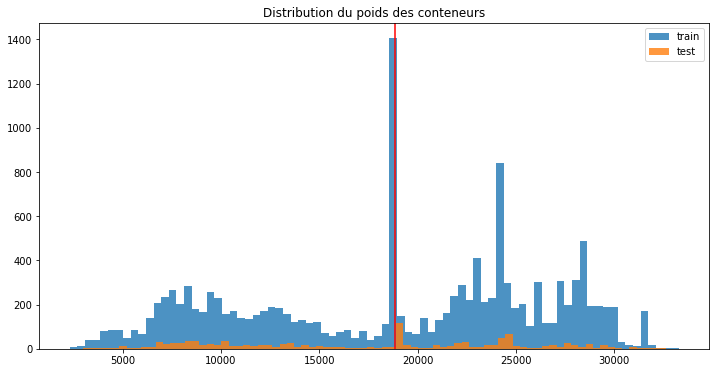

In [284]:
plt.figure(figsize=(12,6))
plt.hist(df['weight'][:13596], bins=80, align="left", label="train", alpha=0.8)
plt.hist(df['weight'][13596:], bins=80, align="right", label="test", alpha=0.8)
#plt.hist(df['actual_day'], bins=80, align="mid")
plt.title("Distribution du poids des conteneurs")
plt.axvline(df['weight'].mean(), c='red')
plt.legend()
plt.show()

In [285]:
df['weight'] = pd.cut(df['weight'], 20)

Cela apporte bien entendu un biais : Nous supposons qu'il existe 20 "catégories" de poids de conteneurs. Dans les faits, il faudrait une connaissance métier afin de pouvoir classifier correctement les types de conteneurs nous parvenant.

In [286]:
df.head()

,id_container,feet,reefer,hazardous,weight,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff
0,AMCU9297612,45,1.0,0.0,"(31931.0, 33480.0]",19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE,2.0,15.0,Wednesday,0
1,MRKU9718477,20,0.0,0.0,"(21088.0, 22637.0]",16A1,BGFREIGHT,JAS,LOGAFRET,COUERON,12.0,30.0,Friday,0
2,MRKU3391638,45,0.0,0.0,"(10245.0, 11794.0]",16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,Friday,0
3,MSKU0794884,40,0.0,0.0,"(10245.0, 11794.0]",16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,Friday,0
4,TEMU2871681,20,0.0,0.0,"(4049.0, 5598.0]",095ACR,CMA,MTTM,NAUL,X,12.0,30.0,Friday,0


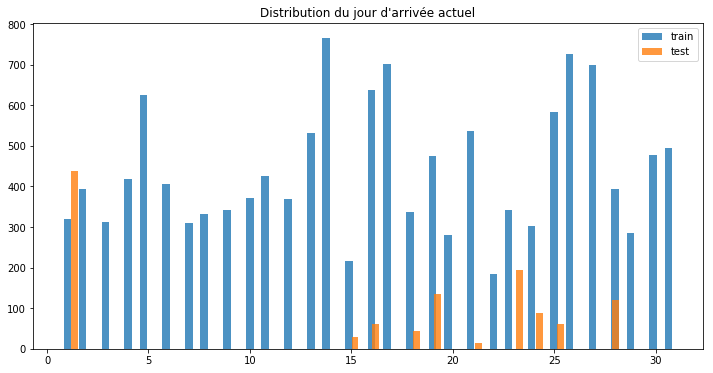

In [287]:
plt.figure(figsize=(12,6))
plt.hist(df['actual_day'][:13596], bins=80, align="left", label="train", alpha=0.8)
plt.hist(df['actual_day'][13596:], bins=80, align="right", label="test", alpha=0.8)
#plt.hist(df['actual_day'], bins=80, align="mid")
plt.title("Distribution du jour d'arrivée actuel")
plt.legend()
plt.show()

In [288]:
days = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

df['actual_day_name'] = df['actual_day_name'].apply(lambda x: days[x])

In [289]:
#df['estimated_day_name'] = df['estimated_day_name'].apply(lambda x: days[x])

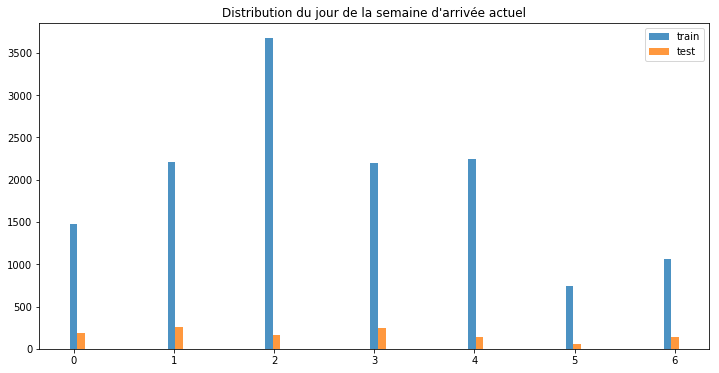

In [290]:
plt.figure(figsize=(12,6))
plt.hist(df['actual_day_name'][:13596], bins=80, align="left", label="train", alpha=0.8)
plt.hist(df['actual_day_name'][13596:], bins=80, align="right", label="test", alpha=0.8)
#plt.hist(df['actual_day'], bins=80, align="mid")
plt.title("Distribution du jour de la semaine d'arrivée actuel")
plt.legend()
plt.show()

La plupart des conteneurs arrivent :
- vers les mois d'été (cf. corrélation avec Independence Day)
- vers le milieu de chaque mois
- le mardi majoritairement

Enfin, on peut s'intéresser au dwell time sur l'échantillon train :

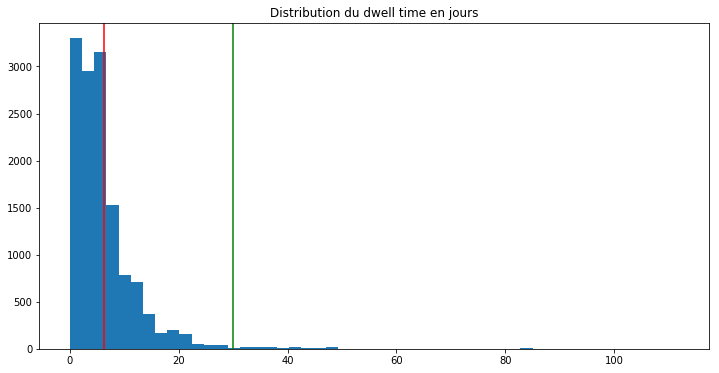

In [291]:
plt.figure(figsize=(12,6))
plt.hist(df_train['dwelltime']/24, bins=50)
plt.title("Distribution du dwell time en jours")
plt.axvline(df_train['dwelltime'].mean()/24, c='red')
plt.axvline(30, c='green')
plt.show()

On remarque que certains dwell time sont particulièrement longs. Il faudrait mettre un point un deuxième classifieur pour ce type de cas plus rares. Nous supposerons ici que tous les dwell times sont de moins de 30 jours, au niveau de la ligne verte.

In [292]:
len(df_train[df_train['dwelltime']<=1200])

13580

In [293]:
len(df_train)

13596

Cela concernerait environ 150 points. Nous pouvons donc les enlever de l'échantillon train. (Fait au moment de séparer les données)

## ID unique

In [294]:
len(df)

14779

In [295]:
df['id_container'].nunique()

14723

Les id ne sont pas uniques. Une visite correspond en effet à un conteneurs qui passe dans un port. L'id ne devrait pas pouvoir être utilisé pour prédire la dwell time idéalement, car la diversité du nombre de conteneurs rendrait cette analyse impossible.

Nous pouvons cependant nous intéresser au conteneurs qui sont revenus plus d'une fois. 
- Combien de fois sont-ils revenus individuellement ?
- Avec la même compagnie de fret?
- Pour la même destination ?

In [296]:
non_unique = pd.DataFrame(df['id_container'].value_counts())
non_unique = non_unique[non_unique['id_container']>1]
non_unique = non_unique.index.tolist()

In [297]:
df_non_unique = pd.DataFrame(columns=df.columns)
for index, row in df.iterrows() :
    if df.loc[index, 'id_container'] in non_unique :
        df_non_unique.loc[index] = df.loc[index]

In [298]:
df_non_unique.sort_values('id_container')[['id_container', 'freight_forwarder', 'trucking_company', 'final_destination']].head(40)

,id_container,freight_forwarder,trucking_company,final_destination
160,AMCU6001537,SETCARGO,AVRIL,ST AIGNAN
3742,AMCU6001537,OTLS,AVRIL,ST AIGNAN
4129,AMFU8832335,GEODIS,BURBAN,DOL DE BRETAGNE
10468,AMFU8832335,ALIZES,HINTERLAND,CARQUEFOU
7730,BMOU6436781,SOGEB,FRANCK,MAGNE
1196,BMOU6436781,SOGEB,NAUL,MAGNE
10893,BMOU6877051,BOL,BURBAN,ST ETIENNE DE MONTLUC
2815,BMOU6877051,BOL,MORAND,CARQUEFOU
13763,CLHU3699315,BOL,HINTERLAND,X
11481,CLHU3699315,BOL,HINTERLAND,X


Les conteneurs sont de manière générale pris en charge par des compagnies différentes et vers des destinations différentes. Seuls 20 conteneurs ont été pris en charge systématiquement par la même compagnie.

In [299]:
len(df_non_unique[['id_container', 'freight_forwarder']])

110

In [300]:
len(df_non_unique[['id_container', 'freight_forwarder']].drop_duplicates())

90

On peut par contre se demander si un conteneur qui est revenu plusieurs fois dans l'année reste en moyenne moins longtemps en stationnement que les autres ?

In [301]:
df_non_unique.join(df_train['dwelltime'])['dwelltime'].describe()

count     102.000000
mean      122.745098
std       223.377702
min         6.000000
25%        36.000000
50%        60.000000
75%       127.500000
max      2132.000000
Name: dwelltime, dtype: float64

In [302]:
df_train['dwelltime'].describe()

count    13596.000000
mean       149.306561
std        154.304552
min          0.000000
25%         55.000000
50%        115.000000
75%        180.000000
max       2685.000000
Name: dwelltime, dtype: float64

Le temps de stationnement reste relativement similaire bien que légèrement inférieur. On peut alors supposer qu'ajouter une variable "AlreadyPassed" peut permettre d'identifier ces conteneurs.

On sélectionne d'abord les conteneurs concernés dans le train :

In [303]:
list_train_to_add = (df_train['id_container'].value_counts()>1).index.tolist()

In [304]:
(df_test['id_container'].value_counts()>1).sum()

0

Il n'y a aucun conteneur dans le test qui soit passé deux fois ou plus. Mais des conteneurs du test seraient-ils deja passés dans le train?

In [305]:
list1=df_train['id_container'].tolist()
list2=df_test['id_container'].tolist()
list_inter = list(set(list1).intersection(list2))
list_inter

['CLHU3699315',
 'CMAU0498562',
 'CXSU1147844',
 'GESU6947953',
 'MEDU6959593',
 'TRIU0460117',
 'GESU5259684',
 'TCLU7423701']

Ces conteneurs sont à la fois dans le train et dans le test.

In [306]:
list(set(list_train_to_add).intersection(list_inter))

['CLHU3699315',
 'CMAU0498562',
 'CXSU1147844',
 'GESU6947953',
 'MEDU6959593',
 'TRIU0460117',
 'GESU5259684',
 'TCLU7423701']

Et chacun de ces conteneurs est deja présent dans la liste des doublons. Nous avons donc identifié la liste complète des conteneurs pour lesquels les nouvelle variable doit être établie à 1.

In [307]:
for index, row in df.iterrows() :
    if df.loc[index, 'id_container'] in non_unique :
        df.loc[index, 'AlreadyPassed'] = 1
    else :
        df.loc[index, 'AlreadyPassed'] = 0

In [308]:
df_unique = df.drop(['id_container'], axis=1)

## Conversion en Labels catégoriques

Une grande partie de nos données contient des données textuelles. Ainsi, il faut les transformer en données catégorielles afin de les rendre interprétables par nos algorithmes.

In [309]:
df_unique.head()

,feet,reefer,hazardous,weight,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff,AlreadyPassed
0,45,1.0,0.0,"(31931.0, 33480.0]",19381S,CMA,FAUVE,HINTERLAND,MONTOIR DE BRETAGNE,2.0,15.0,2,0,0.0
1,20,0.0,0.0,"(21088.0, 22637.0]",16A1,BGFREIGHT,JAS,LOGAFRET,COUERON,12.0,30.0,4,0,0.0
2,45,0.0,0.0,"(10245.0, 11794.0]",16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,4,0,0.0
3,40,0.0,0.0,"(10245.0, 11794.0]",16A1,BGFREIGHT,DAHER,NAUL,ST PIERRE MONTLIMART,12.0,30.0,4,0,0.0
4,20,0.0,0.0,"(4049.0, 5598.0]",095ACR,CMA,MTTM,NAUL,X,12.0,30.0,4,0,0.0


In [310]:
df_unique.dtypes

feet                    int64
reefer                float64
hazardous             float64
weight               category
id_port_call           object
shipping_line          object
freight_forwarder      object
trucking_company       object
final_destination      object
actual_month          float64
actual_day            float64
actual_day_name         int64
time_diff               int64
AlreadyPassed         float64
dtype: object

In [311]:
le = preprocessing.LabelEncoder()

In [312]:
df_unique['weight'] = le.fit_transform(df_unique['weight'])
df_unique['id_port_call'] = le.fit_transform(df_unique['id_port_call'])
df_unique['shipping_line'] = le.fit_transform(df_unique['shipping_line'])
df_unique['freight_forwarder'] = le.fit_transform(df_unique['freight_forwarder'])
df_unique['trucking_company'] = le.fit_transform(df_unique['trucking_company'])
df_unique['final_destination'] = le.fit_transform(df_unique['final_destination'])

In [313]:
df_unique.head()

,feet,reefer,hazardous,weight,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff,AlreadyPassed
0,45,1.0,0.0,19,114,1,15,14,144,2.0,15.0,2,0,0.0
1,20,0.0,0.0,12,55,0,18,15,58,12.0,30.0,4,0,0.0
2,45,0.0,0.0,5,55,0,10,18,226,12.0,30.0,4,0,0.0
3,40,0.0,0.0,5,55,0,10,18,226,12.0,30.0,4,0,0.0
4,20,0.0,0.0,1,1,1,24,18,254,12.0,30.0,4,0,0.0


## Séparer les données train et test

In [314]:
df_cat_train = df_unique[:13596]
len(df_cat_train)

13596

In [315]:
df_cat_train = pd.concat([df_cat_train, df_train['dwelltime']], axis=1)

In [316]:
df_cat_train.head()

,feet,reefer,hazardous,weight,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff,AlreadyPassed,dwelltime
0,45,1.0,0.0,19,114,1,15,14,144,2.0,15.0,2,0,0.0,25
1,20,0.0,0.0,12,55,0,18,15,58,12.0,30.0,4,0,0.0,3
2,45,0.0,0.0,5,55,0,10,18,226,12.0,30.0,4,0,0.0,5
3,40,0.0,0.0,5,55,0,10,18,226,12.0,30.0,4,0,0.0,5
4,20,0.0,0.0,1,1,1,24,18,254,12.0,30.0,4,0,0.0,6


In [317]:
df_cat_train = df_cat_train[df_cat_train['dwelltime']<=720]

In [318]:
df_train = df_train[df_train['dwelltime']<=720]

In [472]:
df_cat_test = df_unique[13596:]
len(df_cat_test)

1183

## Detection d'outliers dans le set d'entrainement

Comme remarqué plus haut, il existe des outliers au niveau de l'écart entre la date d'arrivée prévue et effective.

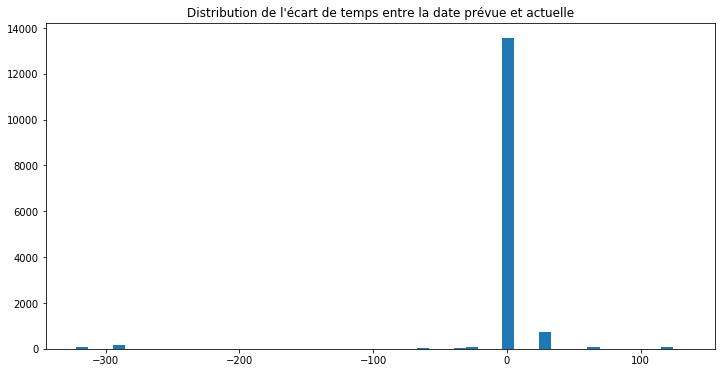

In [320]:
plt.figure(figsize=(12,6))
plt.hist(df_unique['time_diff'], bins=50)
plt.title("Distribution de l'écart de temps entre la date prévue et actuelle")
plt.show()

Dans le set d'entrainement :

In [321]:
df_cat_train['time_diff'].value_counts()

 0      11797
 31       404
 1        314
 30       305
-292      167
 2         89
-1         86
 62        86
-322       61
-30        58
-31        48
 4         18
-61        17
 61         2
Name: time_diff, dtype: int64

In [322]:
df_cat_train['time_diff'].describe()

count    13452.000000
mean        -3.350059
std         40.050745
min       -322.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         62.000000
Name: time_diff, dtype: float64

Dans le set de test :

In [323]:
df_cat_test['time_diff'].describe()

count    1183.000000
mean        7.690617
std        29.581268
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       133.000000
Name: time_diff, dtype: float64

Etant donné que nous n'avons pas plus d'information sur la nature des cas ou la date d'arrivée prévue est située 50, 100 ou 200 jours après la date effective d'arrivée, qu'il n'y a pas d'exemple similaire dans le set de test, et que globalement la volumétrie de ce problème est négligeable, on considère que l'on peut supprimer ces exemples.

In [324]:
len(df_cat_train)

13452

In [325]:
df_cat_train[(df_cat_train['time_diff'])>=0]['time_diff'].describe()

count    13015.000000
mean         2.127699
std          8.511501
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         62.000000
Name: time_diff, dtype: float64

Nous allons ré-utiliser le set df_train ultérieurement pour obtenir le dwell time. Nous devons donc supprimer les observations supprimées ici également.

In [326]:
df_train = df_train[(df_cat_train['time_diff']>=0)]

In [327]:
df_cat_train = df_cat_train[(df_cat_train['time_diff'])>=0]

In [328]:
df_cat_train.shape

(13015, 15)

# Principal Component Analysis, Feature Importance

## Matrice de correlation

In [329]:
df.select_dtypes(include=[np.float64, np.int]).corr()

,feet,reefer,hazardous,actual_month,actual_day,actual_day_name,time_diff,AlreadyPassed
feet,1.000000,0.021495,0.003167,-0.026080,-0.006959,-0.012644,0.007303,0.010251
reefer,0.021495,1.000000,-0.015237,-0.006431,-0.005196,0.021278,0.012519,-0.009230
hazardous,0.003167,-0.015237,1.000000,0.006230,-0.018584,0.017196,0.005140,-0.001141
actual_month,-0.026080,-0.006431,0.006230,1.000000,-0.043188,0.011069,0.202902,-0.009751
actual_day,-0.006959,-0.005196,-0.018584,-0.043188,1.000000,-0.149079,-0.033974,-0.004487
actual_day_name,-0.012644,0.021278,0.017196,0.011069,-0.149079,1.000000,-0.055120,0.036149
time_diff,0.007303,0.012519,0.005140,0.202902,-0.033974,-0.055120,1.000000,0.002690
AlreadyPassed,0.010251,-0.009230,-0.001141,-0.009751,-0.004487,0.036149,0.002690,1.000000


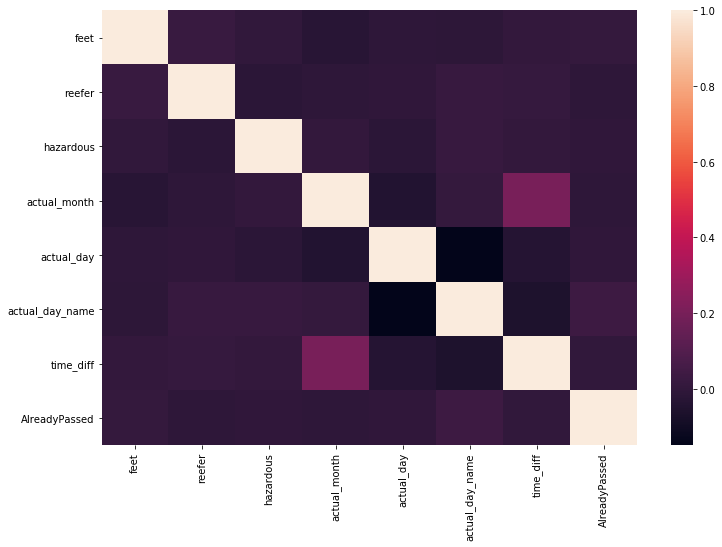

In [330]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(df.select_dtypes(include=[np.float64, np.int]).corr(), xticklabels=True, yticklabels=True)

## Importance des variables

Text(0.5, 1.0, 'Feature importance')

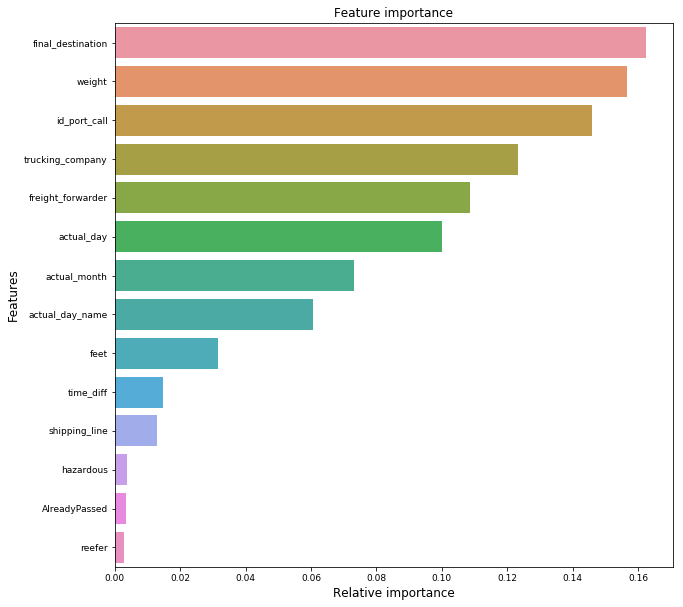

In [331]:
plt.figure(figsize=(10,10))

name = "Random Forest"

rf = RandomForestRegressor(criterion='mae')
rf.fit(df_cat_train.drop(['dwelltime'], axis=1),df_cat_train['dwelltime'])

indices = np.argsort(rf.feature_importances_)[::-1][:40]
g = sns.barplot(y=df_cat_train.drop(['dwelltime'], axis=1).columns[indices][:40],x = rf.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")

A titre informatif, avant One Hot Encoding, les valeurs qui semblent parlantes sont :
- la destination finale
- l'id du port call
- la catégorie de poids

## Analyse en Composantes Pincipales

In [332]:
def myPCA(df, clusters=None):
    # Normalize data
    df_norm = (df - (df.mean())) / (df.std())
    # PCA
    pca = PCA(n_components=7)
    global pca_res
    pca_res = pca.fit_transform(df_norm.values)
    print("Variance explained : " + str(pca.explained_variance_ratio_.sum()))
    # Ebouli
    plt.figure(figsize=(12,6))
    ebouli = pd.Series(pca.explained_variance_ratio_)
    ebouli.plot(kind='line', title="Scree Plot of the Eigen Values")
    plt.show()
    
    # Circle of correlations
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(ebouli))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    plt.figure(figsize=(12,12))
    circleOfCorrelations(pc_infos, ebouli)
    plt.show()
    

    return pc_infos, ebouli

def circleOfCorrelations(pc_infos, ebouli):
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='b', fill=False)
    circle2=plt.Circle((0,0),radius=0.5, color='b', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    fig.gca().add_artist(circle2)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x-0.05,y-0.05))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")

Variance explained : 0.6341049208740752


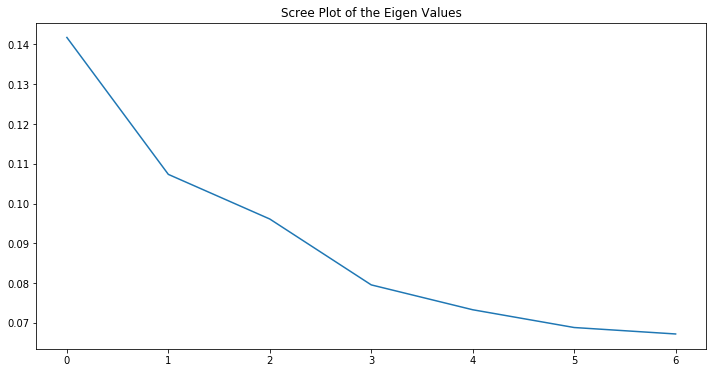

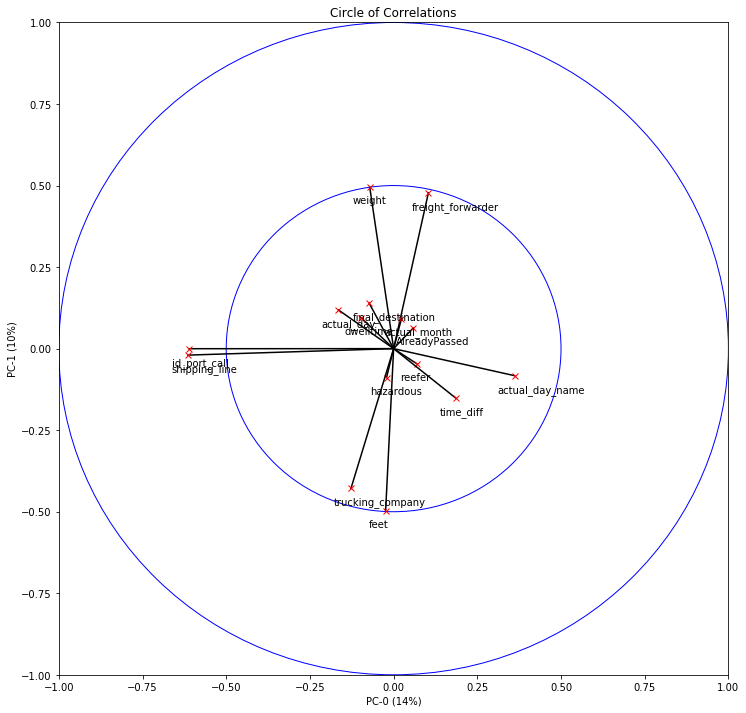

In [333]:
pc_infos, ebouli = myPCA(df_cat_train)

Les composantes permettant d'expliquer le Dwell Time semblent difficile à corréler avec le Dwell Time étant donné la faible corrélation. Cependant, les directions projetées sur les deux premiers axes permettent de dire que :
- l'actual day, final destination, shipping line, id port call ou weight sont autant d'élément qui permettront potentiellement d'expliquer le modèle
- la conclusion semble similaire avec l'importance estimée des variables par le Random Forest Regressor ci-dessus

# Créer le modèle

## Definition de la métrique

La métrique sélectionnée est la Mean Absolute Percentage Error.

In [334]:
def mean_absolute_percentage_error(y_true, y_pred): 
    result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return result

In [335]:
df_cat_train = df_cat_train.reset_index(drop=True)

Il peut y avoir des problèmes si le dwell time vaut 0 à un moment.

In [336]:
df_cat_train[df_cat_train['dwelltime']<1]

,feet,reefer,hazardous,weight,id_port_call,shipping_line,freight_forwarder,trucking_company,final_destination,actual_month,actual_day,actual_day_name,time_diff,AlreadyPassed,dwelltime
10062,20,0.0,0.0,16,270,3,20,8,181,12.0,10.0,6,30,0.0,0
10064,20,0.0,0.0,16,270,3,20,8,181,12.0,10.0,6,30,0.0,0


La volumétrie est négligeable, on peut supprimer ces deux lignes.

In [337]:
df_cat_train = df_cat_train[df_cat_train['dwelltime']>0]

In [338]:
X = df_cat_train.drop(['dwelltime'], axis=1)
y = df_cat_train['dwelltime']

In [339]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=0.10, random_state=42)

In [340]:
enc = OneHotEncoder(handle_unknown='ignore')
X_oh = enc.fit_transform(X)   

In [341]:
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y, test_size=0.10, random_state=42)

## K-Nearest Neighbors

In [342]:
mape = []
for k in range(1,10) :
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train_oh, y_train_oh) 
    y_pred_oh = neigh.predict(X_test_oh)
    mape.append(mean_absolute_percentage_error(y_test_oh, y_pred_oh))

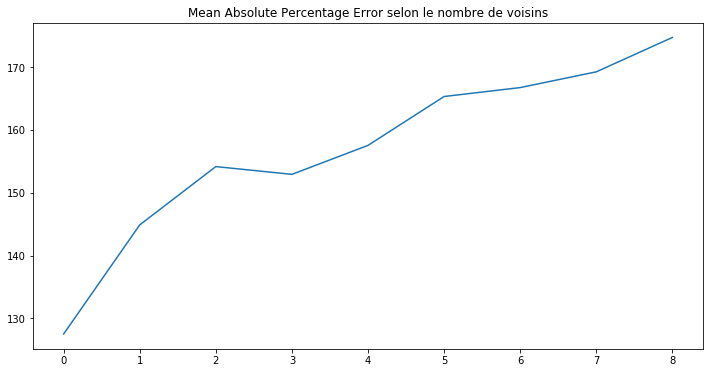

In [343]:
plt.figure(figsize=(12,6))
plt.plot(mape)
plt.title("Mean Absolute Percentage Error selon le nombre de voisins")
plt.show()

Cette approche semble instable car le nombre de dimensions est trop élevé et que des voisins en ce sens d'une distance Euclidienne peuvent être particulièrement éloignés.

## Random Forest

Deux approches sont testées ici :
- avec un Label Encoder
- avec le One Hot Encoder

### Label Encoder

In [344]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_label, y_train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [345]:
y_pred_label = rf.predict(X_test_label)

In [346]:
mean_absolute_percentage_error(y_test_label, y_pred_label)

120.85591523400862

### One Hot Encoder

In [347]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_oh, y_train_oh)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [348]:
y_pred_oh = rf.predict(X_test_oh)

In [349]:
mean_absolute_percentage_error(y_test_oh, y_pred_oh)

110.40176275215532

Le Label Encoder semble fonctionner systématiquement moins bien que le One Hot Encoder. Pour cette raison, j'ai décidé de conserver unqiuemenet l'approche One Hot Encoder.

## Gradient Boosting Methods

In [350]:
reg_gbm = xgb.XGBRegressor(learning_rate = 0.0005, n_estimators=1000, max_depth=30)
reg_gbm.fit(X_train_oh, y_train_oh)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0005, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [351]:
y_pred_oh = reg_gbm.predict(X_test_oh)

In [352]:
mean_absolute_percentage_error(y_test_oh, y_pred_oh)

80.42707038785028

## Dimension Reduction

In [353]:
pca = PCA(n_components=100)
pca_res = pca.fit_transform(X_oh.toarray())

In [354]:
pca.explained_variance_ratio_.sum()

0.8522155076854848

In [355]:
pca_cum = []
total = 0
for val in pca.explained_variance_ratio_ :
    total = total + val
    pca_cum.append(total)

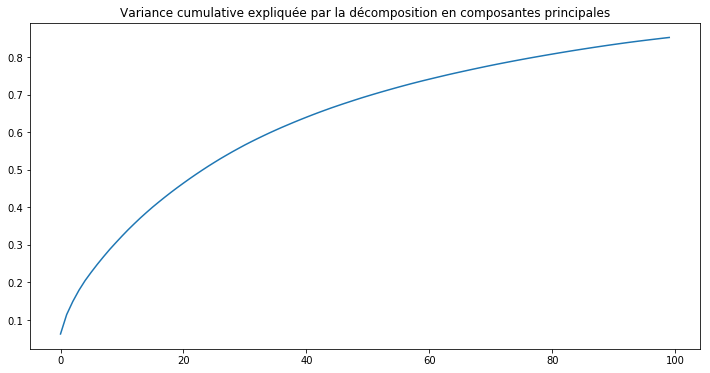

In [356]:
plt.figure(figsize=(12,6))
plt.plot(pca_cum)
plt.title("Variance cumulative expliquée par la décomposition en composantes principales")
plt.show()

In [357]:
pca = PCA(n_components=60)
pca_res = pca.fit_transform(X_oh.toarray())

In [363]:
X = X_oh.toarray()
y = df_cat_train['dwelltime']

On peut maintenant appliquer une Random Forest :

In [366]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.10, random_state=42)

In [367]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_pca, y_train_pca)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [368]:
y_pred_pca = rf.predict(X_test_pca)

In [369]:
mean_absolute_percentage_error(y_test_pca, y_pred_pca)

112.21159406721341

La réduction de dimension n'apporte que peu de résultats mais peut s'avérer être plus stable car le nombre de dimensions en entrée est divisé par 6.

## Artificial Neural Network

Bien que nous ne disposons que de peu de données, une approche par Deep Learning devrait offrir des résultats intéressants de par notamment la complexité du set de données.

"The properties of the ANN used for the training method are 2000 training cycles, 4 hidden layers of 25 nodes each, a network learning rate of 0.05 and a momentum term of 0.2."
https://www.sciencedirect.com/science/article/pii/S2352146516300618

In [458]:
model=Sequential()

model.add(Dense(100, input_dim=681, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(100, input_dim=100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(100, input_dim=100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(100, input_dim=100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(1, input_dim=100, kernel_initializer='normal', activation='relu'))

#model.add(Dense(1, kernel_initializer='normal'))
#sgd = SGD(lr=0.1, momentum=0.8)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

L'architecture du modèle est inspirée du papier de recherche cité ci-dessus. Cependant :
- notre nombre de variables est pls élevé, chaque couche du réseau possède donc plus de neurones
- pour gérer les valeurs négatives, nous optons pour la LeakyRelu
- le droput et le batch normalisation permettent de grandement limiter l'overfitting
- un optimiseur Adam est retenu après plusieurs tests
- le batch size est fixé à 5
- nous apprenons sur 100 epochs pour des questions de temps

In [459]:
X_train_oh.shape

(11711, 681)

In [460]:
model.fit(X_train_oh, y_train_oh, epochs=30, batch_size=5, verbose=1, validation_split=0.15)

Train on 9954 samples, validate on 1757 samples
Epoch 1/30
9954/9954 [==============================] - 17s 2ms/step - loss: 90.7841 - val_loss: 83.7360
Epoch 2/30
9954/9954 [==============================] - 13s 1ms/step - loss: 82.4396 - val_loss: 79.7857
Epoch 3/30
9954/9954 [==============================] - 12s 1ms/step - loss: 79.9914 - val_loss: 77.5845
Epoch 4/30
9954/9954 [==============================] - 12s 1ms/step - loss: 77.3683 - val_loss: 77.7872
Epoch 5/30
9954/9954 [==============================] - 12s 1ms/step - loss: 75.4295 - val_loss: 76.3260
Epoch 6/30
9954/9954 [==============================] - 15s 1ms/step - loss: 75.6558 - val_loss: 76.3514
Epoch 7/30
9954/9954 [==============================] - 15s 2ms/step - loss: 74.7025 - val_loss: 75.6192
Epoch 8/30
9954/9954 [==============================] - 13s 1ms/step - loss: 73.1458 - val_loss: 74.7446
Epoch 9/30
9954/9954 [==============================] - 12s 1ms/step - loss: 73.6716 - val_loss: 74.7892
Epoch 1

In [463]:
# serialize model to JSON
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model/model.h5")
print("Saved model to disk")

Saved model to disk


In [464]:
# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Loaded model from disk")

Loaded model from disk


Remarque :
- la convergence peut être améliorée
- il y a un léger overfitting
- certaines valeurs de loss sont instables
- de manière générale, le modèle pourrait être mieux calibré et tourner plus longtemps

In [465]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               68200     
_________________________________________________________________
dropout_48 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 100)               400       
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 100)               400       
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
__________

In [467]:
prediction = loaded_model.predict(X_test_oh)

In [468]:
mean_absolute_percentage_error(y_test_oh, prediction.flatten())

69.9560156194187

# Meilleurs résultats

In [469]:
submissions = {}
submissions['0'] = ['KNN', '3 Neighbors', 0, 1, "Avec Mois Estimé", 145]
submissions['2'] = ['Random Forest', '100 estimateurs, Critère MSE', 1, 0, "Avec Already Passed", 120.5]
submissions['4'] = ['Random Forest', '100 estimateurs, Critère MSE', 0, 1, "Avec Already Passed", 110.40]
submissions['5'] = ['PCA before Random Forest', '100 estimateurs, Critère MSE', 0, 1, "Avec Mois Estimé, Avec Already Passed", 112.5]
submissions['6'] = ['XGBoost', '1000 estimateurs, lr=0.0005, max_depth=30', 0, 1, "Avec Mois Estimé", 80.42]
submissions['7'] = ['ANN', '100 epochs, Adam loss', 0, 1, "4 Hidden layers", 69.95]

In [470]:
subs_df = pd.DataFrame.from_dict(
    submissions, 
    orient='index',
    columns=['model','Parameters', 'Label Encoder', 'One Hot Encoder', 'Detail Train Set', 'MAPE'])

subs_df.sort_values('MAPE')

,model,Parameters,Label Encoder,One Hot Encoder,Detail Train Set,MAPE
7,ANN,"100 epochs, Adam loss",0,1,4 Hidden layers,69.95
6,XGBoost,"1000 estimateurs, lr=0.0005, max_depth=30",0,1,Avec Mois Estimé,80.42
4,Random Forest,"100 estimateurs, Critère MSE",0,1,Avec Already Passed,110.40
5,PCA before Random Forest,"100 estimateurs, Critère MSE",0,1,"Avec Mois Estimé, Avec Already Passed",112.50
2,Random Forest,"100 estimateurs, Critère MSE",1,0,Avec Already Passed,120.50
0,KNN,3 Neighbors,0,1,Avec Mois Estimé,145.00


L'approche par deep learning semble produire les meilleurs résultats. Il est cependant important de souligner que nous la volumétrie actuelle nous permet difficilement de tirer des conclusions de l'efficacité du deep learning.

# Prediction

## Vers CSV

In [473]:
enc.transform(df_cat_test)

<1183x681 sparse matrix of type '<class 'numpy.float64'>'
	with 15303 stored elements in Compressed Sparse Row format>

In [474]:
df_cat_test = enc.transform(df_cat_test)

In [475]:
prediction = pd.DataFrame(loaded_model.predict(df_cat_test))

In [476]:
prediction.to_csv("prediction.csv")

## Intervalle de confiance

In [477]:
prediction.describe()

,0
count,1183.000000
mean,30.031837
std,11.998588
min,0.000000
25%,21.272823
50%,30.672049
75%,37.618608
max,93.774849


In [478]:
pd.DataFrame(y_train_oh).describe()

,dwelltime
count,11711.000000
mean,140.178038
std,116.090806
min,1.000000
25%,55.000000
50%,114.000000
75%,176.000000
max,719.000000


La prediction semble globalement trop conservative par rapport aux données d'entrainement

<Figure size 864x432 with 0 Axes>

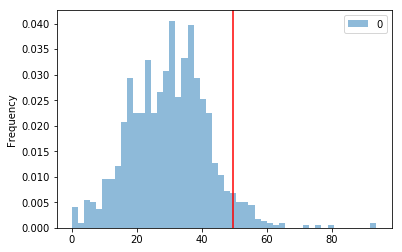

In [479]:
plt.figure(figsize=(12,6))
prediction.plot.hist(bins=50, alpha=0.5, density=True, label="Prediction")
#y_train_oh.plot.hist(bins=50, alpha=0.5, density=True, label="ytrain")
plt.axvline(np.percentile(prediction,95), color='red')
plt.legend()
plt.show()

In [480]:
lower = prediction.mean()-prediction.std()*1.96
upper = prediction.mean()+prediction.std()*1.96

In [481]:
np.percentile(prediction,95)

49.74634704589843

In [482]:
lower[0]

6.5146046

In [483]:
upper[0]

53.549072

En suivant une hypothèse gaussienne (trop?) simpliste, 95% des données sont réparties entre 1 et 68 heures de temps de stationnement.